### Dinucleodite counting and context of methylation

In [1]:
%matplotlib inline
import pandas as pd
import os
import re
from pybedtools import BedTool
import numpy as np
import pybedtools
import re
import matplotlib.pyplot as plt
import json
import matplotlib
import subprocess
import numpy as np
import collections
import seaborn as sns

In [87]:
from IPython.display import Image

In [4]:
### a bit of a quick hack

In [5]:
def facount(in_fn, out_fn):
    cmd = 'faCount -dinuc %s > %s' % \
    (os.path.abspath(in_fn), os.path.abspath(out_fn))
    output = subprocess.run(cmd, shell=True)
    return output.returncode

In [6]:
def do_RIP_call(fac_fn):
    "Return pandas dataframe with caculations reading in the faCount outfile."
    faC_header = ['seqID','len','A','C','G','T','N','cpg','AA','AC','AG',
                 'AT','CA','CC','CG','CT','GA','GC','GG','GT','TA','TC','TG','TT']
    count_dict = {}
    for n_pattern in faC_header:
        count_dict[n_pattern] = []
    dtypes = {}
    for x in faC_header:
        dtypes[x] = 'int'
    dtypes['seqID'] = 'str'
    with open(fac_fn) as fh: 
        for line in fh:
            line = line.rstrip()
            split_line = re.split('\t', line)
            if not line.startswith('#'):
                #if len(split_line) > len(faC_header):
                  #  split_line = split_line[0:len(faC_header)+1]

                for n_pattern, value in zip(faC_header, split_line):
                    count_dict[n_pattern].append(value)
    df = pd.DataFrame.from_dict(count_dict)
    df = df.astype(dtypes)
    df['TpA/ApT'] = df['TA']/df['AT']
    df['CpA + TpG/ApC + GpT'] = (df['CA'] + df['TG'])/(df['AC']+df['GT'])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

In [7]:
def dinuc_bed(infn, outfn):
    """
    Takes bedfile of single positions of methylation to append the second position
    for dinucledote counting depeneding on the strand.
    Input:
        infn: Bedfile of individually called methylation sides e.g. from tombo.
        outfn: Name of the outfile.
    Output:
        None.
    """
    with open(infn, 'r') as infh:
        with open(outfn, 'w') as outfn:
            for line in infh:
                line = line.rstrip()
                line_split = line.split('\t')
                start = line_split[1]
                stop = line_split[2]
                strand = line_split[5]
                if strand == '+':
                    stop = int(stop) + 1
                elif strand == '-':
                    start = int(start) -1
                new_line = F'{line_split[0]}\t{start}\t{stop}\t{line_split[3]}\t{line_split[4]}\t{strand}'
                print(new_line, file = outfn)

In [8]:
def dinuc_bed_count(infn):
    """
    Takes a fasta file of dinucleotide entries. Counts them and returns a dataframe of the counts.
    Input:
        Fasta file of dinucleotides.
    Return:
        Dataframe of dinucleotide counts.
    """
    dinuc_dict = collections.Counter()
    with open(infn, 'r') as fh:
        for line in fh:
            if not line.startswith('>'):
                dinuc = line.rstrip().upper()
                dinuc_dict[dinuc] += 1
    for key, value in dinuc_dict.items():
        dinuc_dict[key] = [value]
    return pd.DataFrame.from_dict(dinuc_dict).T

In [9]:
def get_dinuc_freq_df(genome_dinuc_df, observed_dinuc_df):
    """
    Takes df having the genome dinucleotide frequences and a df with the observed dinucleotide frequences in the data.
    Returns a dataframe that combines most useful results.
    
    """
    last_index = genome_dinuc_df.shape[0] - 1
    tmp_df = observed_dinuc_df/observed_dinuc_df.sum()
    tmp_df.rename(columns={0:'ob_dinuc_freq'},inplace = True)
    tmp_df['ob_dinuc_total'] = observed_dinuc_df[0].tolist()
    #because 
    reverse_index = []
    for ind in tmp_df.index:
        reverse_index.append(reverse_comp_dinuc(ind))
    tmp_df['genome_dinuc_total'] = (genome_dinuc_df.loc[last_index,tmp_df.index].reset_index(drop=True)\
                              +  genome_dinuc_df.loc[last_index,reverse_index].reset_index(drop=True)).tolist()
    #tmp_df['genome_total'] = tmp_df['genome_total'] + genome_dinuc_df.loc[last_index,reverse_index]
    tmp_df['genome_dinuc_freq'] = tmp_df['genome_dinuc_total']/tmp_df['genome_dinuc_total'].sum()
    tmp_df['meth_freq'] = tmp_df['ob_dinuc_total']/tmp_df['genome_dinuc_total']
    return tmp_df    

In [10]:
def reverse_comp_dinuc(dinucstring):
    nuc_dic = {'A': 'T', 'T': 'A', 'G': 'C', 'C' : 'G'}
    dinucreverse = ''
    for s in dinucstring[::-1]:
        dinucreverse = dinucreverse + nuc_dic[s]
    return dinucreverse
    

In [11]:
genome_file_fn = os.path.abspath('../../data/genomic_resources/Pgt_genome_size.txt')
genome_assembly_fn = os.path.abspath('../../data/genomic_resources/chr_A_B_unassigned.fasta')

In [12]:
###For Tombo
BEDDIRDICT = {}
BEDDIRDICT['infected_leaves'] = os.path.abspath('../../analyses/methylation_calling/infected_leaves/bed_files')
BEDDIRDICT['germinated_spores'] = os.path.abspath('../../analyses/methylation_calling/germinated_spores/bed_files')

In [13]:
OUTDIR = os.path.abspath('../../analyses/methylation_analysis/dinuc')

In [14]:
print(OUTDIR)

/home/jamila/jamila_Storage/analyses/methylation_analysis/dinuc


In [15]:
####calculate the background genome rates of dinucleotides
genome_dinuc_fn = os.path.join(OUTDIR, os.path.basename(genome_assembly_fn).replace('.fasta', '.fac'))
facount(genome_assembly_fn, genome_dinuc_fn)
genome_dinuc_df = do_RIP_call(genome_dinuc_fn)

In [24]:
fa_fn_dict = {}
dinuc_bed_fn_dict = {}
dinuc_df_dict = {}
for key in BEDDIRDICT.keys():
    for mod in ['5mC', '6mA']:
        for cutoff in ['g03', 's03', 'g05', 's05']:
            new_key = F'{key}-{mod}-{cutoff}'
            #print(key, mod, cutoff)
            tmp_in_bed_fn = os.path.join(BEDDIRDICT[key], F'{key}.{mod}.{cutoff}.tombo.bed')
            tmp_dinuc_bed_fn = os.path.join(OUTDIR, os.path.basename(tmp_in_bed_fn).replace('.bed', '.dinuc.bed'))
            dinuc_bed_fn_dict[new_key] = tmp_in_bed_fn
            #generate dinucleotide bed
            dinuc_bed(tmp_in_bed_fn, tmp_dinuc_bed_fn)
            tmp_fa_fn = tmp_dinuc_bed_fn.replace('.bed', '.fasta')
            fa_fn_dict[new_key] = tmp_fa_fn
            #get the corresponding fa file
            !bedtools getfasta -fi {genome_assembly_fn} -bed {tmp_dinuc_bed_fn} -s > {tmp_fa_fn}
            #now get the dinuc_dict
            dinuc_df_dict[new_key] = dinuc_bed_count(tmp_fa_fn)
            print(tmp_in_bed_fn)

/home/jamila/jamila_Storage/analyses/methylation_calling/infected_leaves/bed_files/infected_leaves.5mC.g03.tombo.bed
/home/jamila/jamila_Storage/analyses/methylation_calling/infected_leaves/bed_files/infected_leaves.5mC.s03.tombo.bed
/home/jamila/jamila_Storage/analyses/methylation_calling/infected_leaves/bed_files/infected_leaves.5mC.g05.tombo.bed
/home/jamila/jamila_Storage/analyses/methylation_calling/infected_leaves/bed_files/infected_leaves.5mC.s05.tombo.bed
/home/jamila/jamila_Storage/analyses/methylation_calling/infected_leaves/bed_files/infected_leaves.6mA.g03.tombo.bed
/home/jamila/jamila_Storage/analyses/methylation_calling/infected_leaves/bed_files/infected_leaves.6mA.s03.tombo.bed
/home/jamila/jamila_Storage/analyses/methylation_calling/infected_leaves/bed_files/infected_leaves.6mA.g05.tombo.bed
/home/jamila/jamila_Storage/analyses/methylation_calling/infected_leaves/bed_files/infected_leaves.6mA.s05.tombo.bed
/home/jamila/jamila_Storage/analyses/methylation_calling/germina

In [17]:
#for a re-run pull in the 
fa_fn_dict = {}
dinuc_bed_fn_dict = {}
dinuc_df_dict = {}
for key in BEDDIRDICT.keys():
    for mod in ['5mC', '6mA']:
        for cutoff in ['g03', 's03', 'g05', 's05']:
            new_key = F'{key}-{mod}-{cutoff}'
            tmp_in_bed_fn = os.path.join(BEDDIRDICT[key], F'{key}.{mod}.{cutoff}.tombo.bed')
            tmp_dinuc_bed_fn = os.path.join(OUTDIR, os.path.basename(tmp_in_bed_fn).replace('.bed', '.dinuc.bed'))
            dinuc_bed_fn_dict[new_key] = tmp_in_bed_fn
            tmp_fa_fn = tmp_dinuc_bed_fn.replace('.bed', '.fasta')
            fa_fn_dict[new_key] = tmp_fa_fn
            dinuc_df_dict[new_key] = dinuc_bed_count(tmp_fa_fn)

In [80]:
sns.set_context("poster", font_scale=2)

In [79]:
sns.set(style="white", font_scale=2)

In [64]:
tmp_df2 = tmp_df.loc[sorted(tmp_df.index.tolist()), ['ob_dinuc_freq', 'genome_dinuc_freq']]

    ob_dinuc_freq  ob_dinuc_total  genome_dinuc_total  genome_dinuc_freq  \
CA       0.251703         2689564            25015364           0.325412   
CC       0.254215         2716413            19139188           0.248972   
CT       0.209829         2242129            21976219           0.285877   
CG       0.284253         3037379            10742142           0.139739   

    meth_freq  
CA   0.107516  
CC   0.141929  
CT   0.102025  
CG   0.282754  
    ob_dinuc_freq  ob_dinuc_total  genome_dinuc_total  genome_dinuc_freq  \
CT       0.301016        17026588            21976219           0.285877   
CC       0.252038        14256188            19139188           0.248972   
CA       0.339844        19222842            25015364           0.325412   
CG       0.107102         6058094            10742142           0.139739   

    meth_freq  
CT   0.774773  
CC   0.744869  
CA   0.768441  
CG   0.563956  
    ob_dinuc_freq  ob_dinuc_total  genome_dinuc_total  genome_dinuc_freq  \
CG

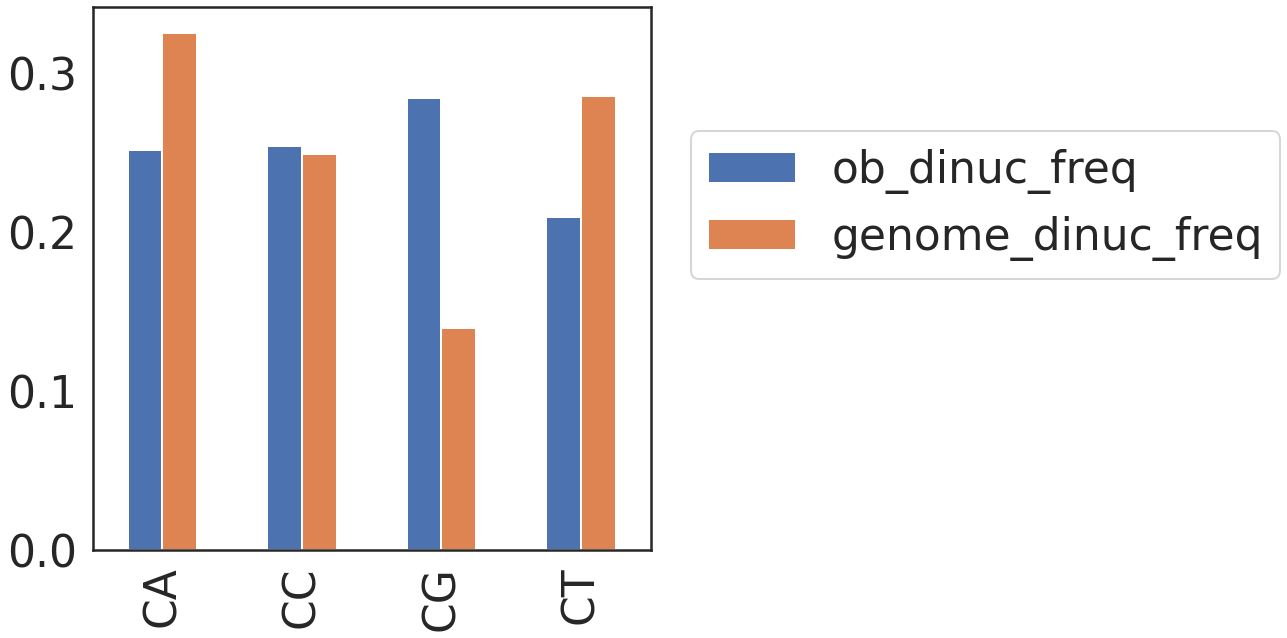

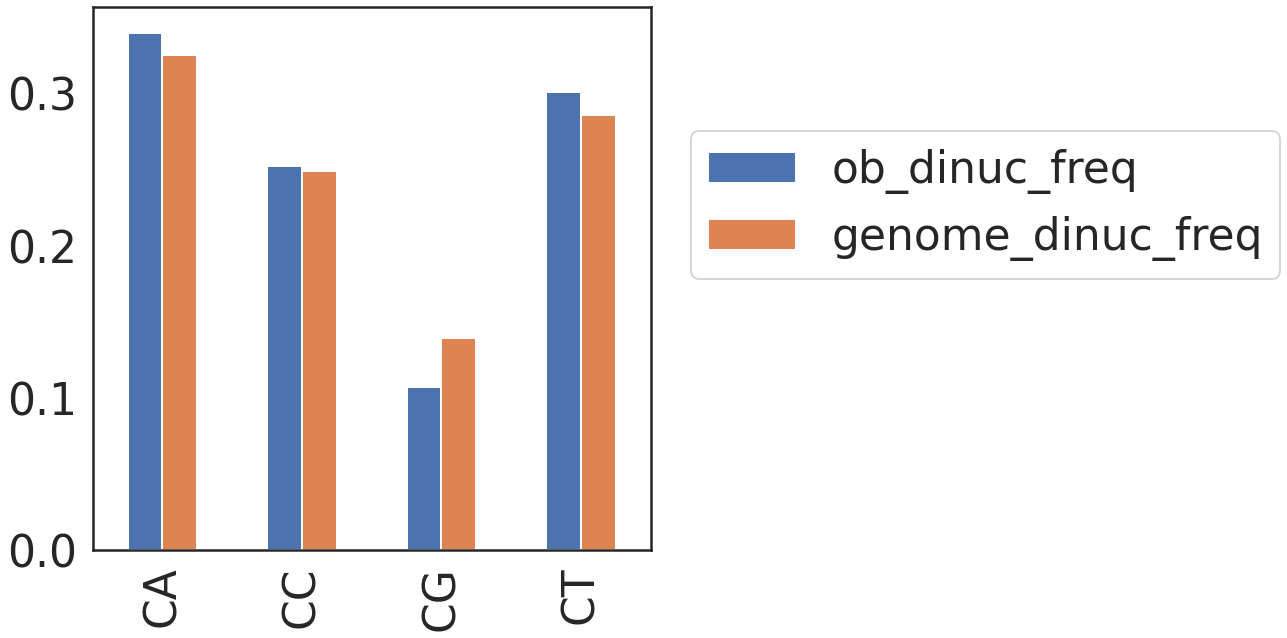

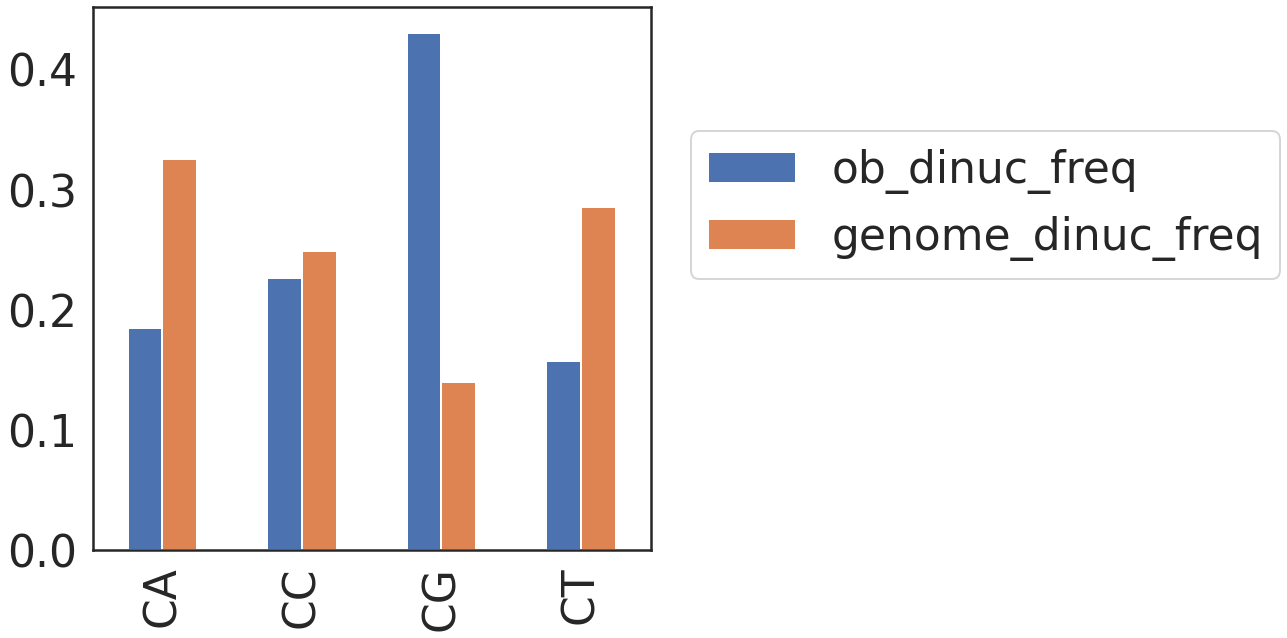

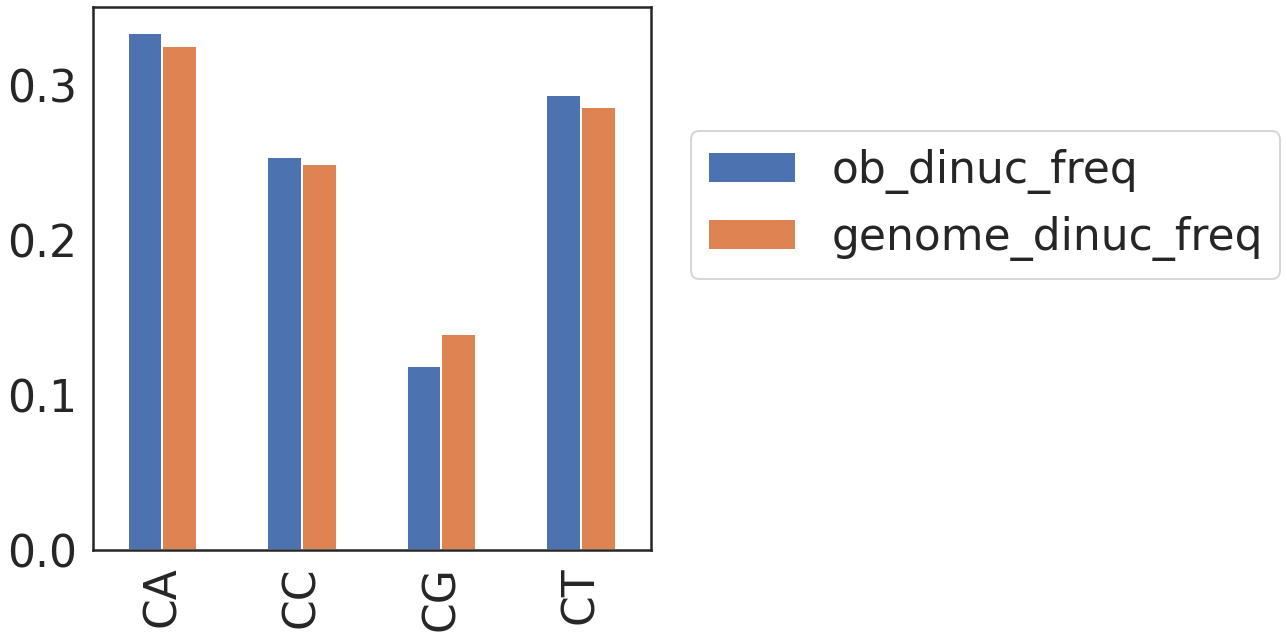

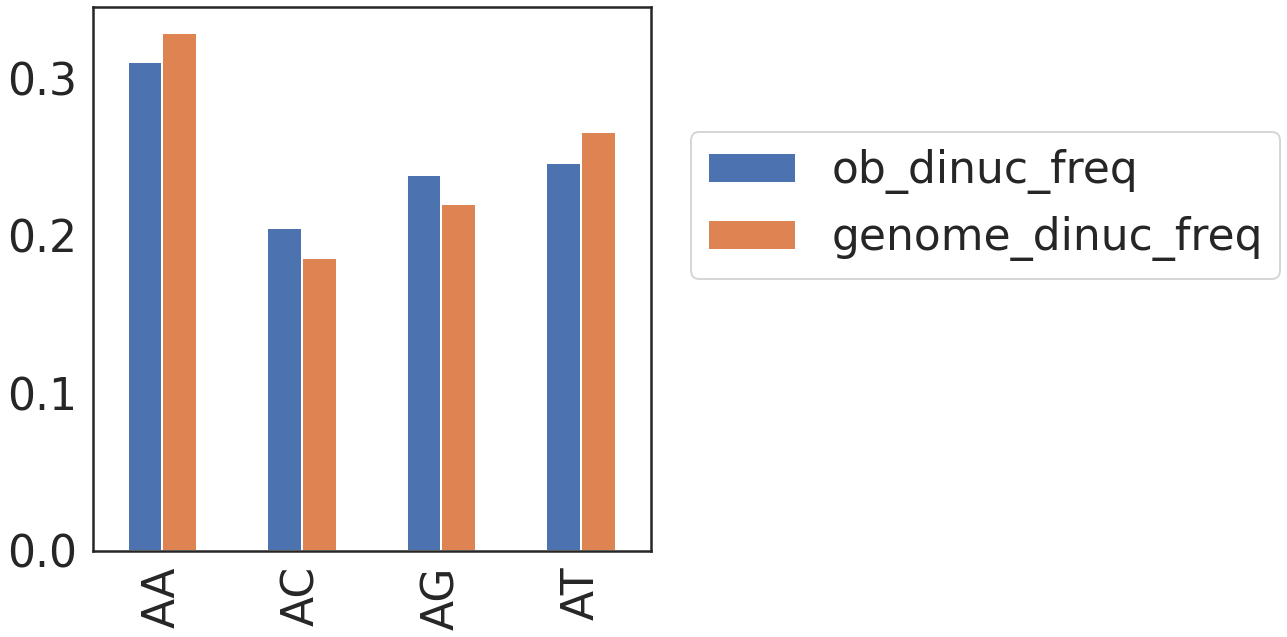

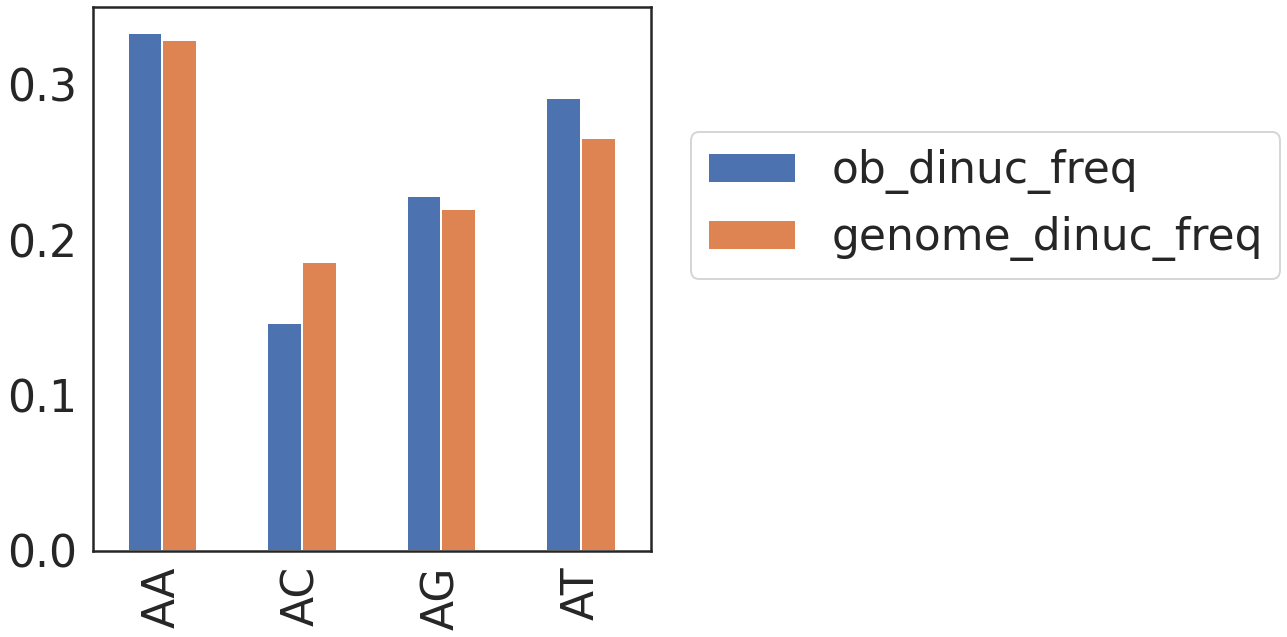

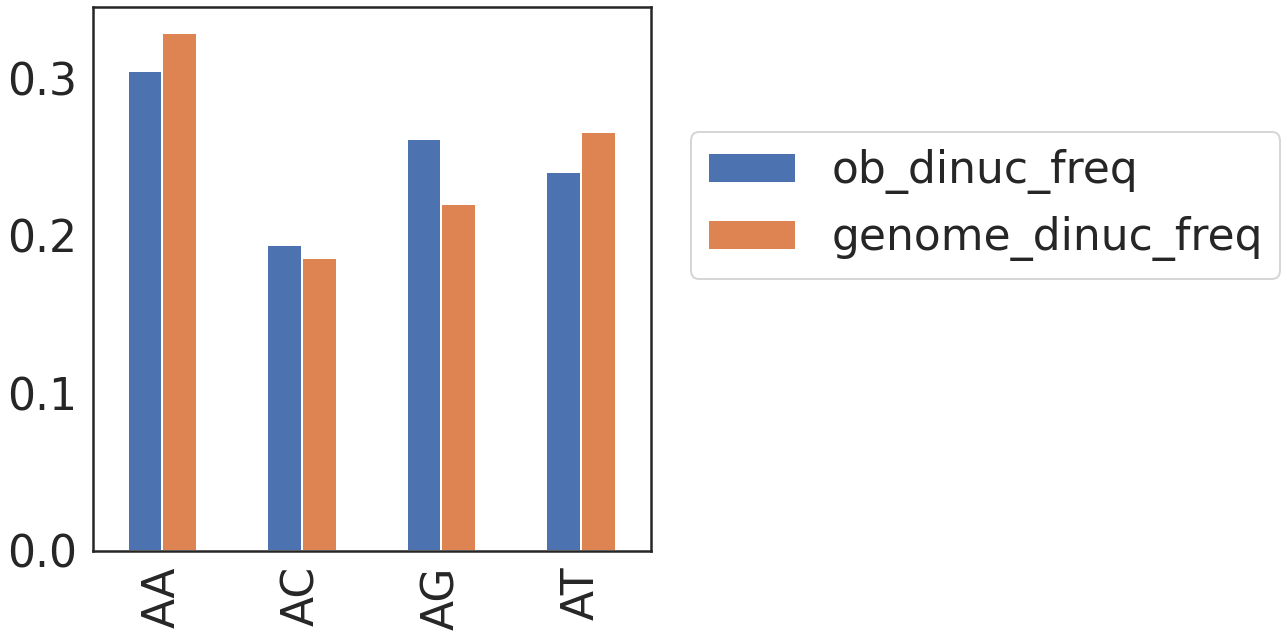

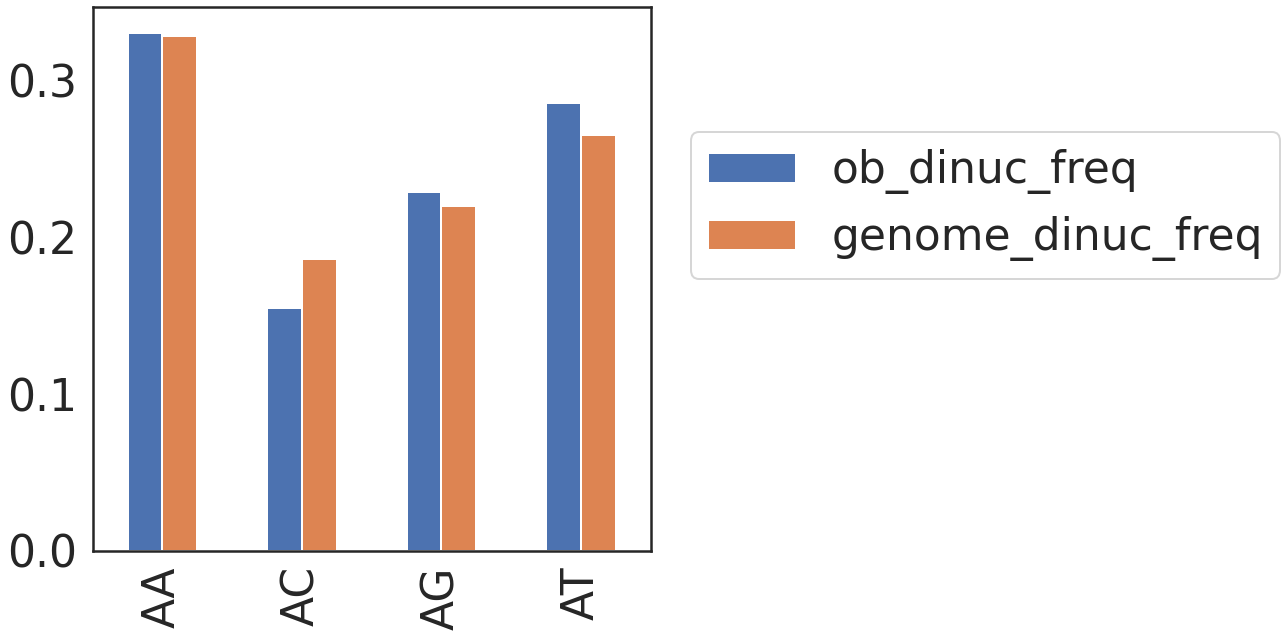

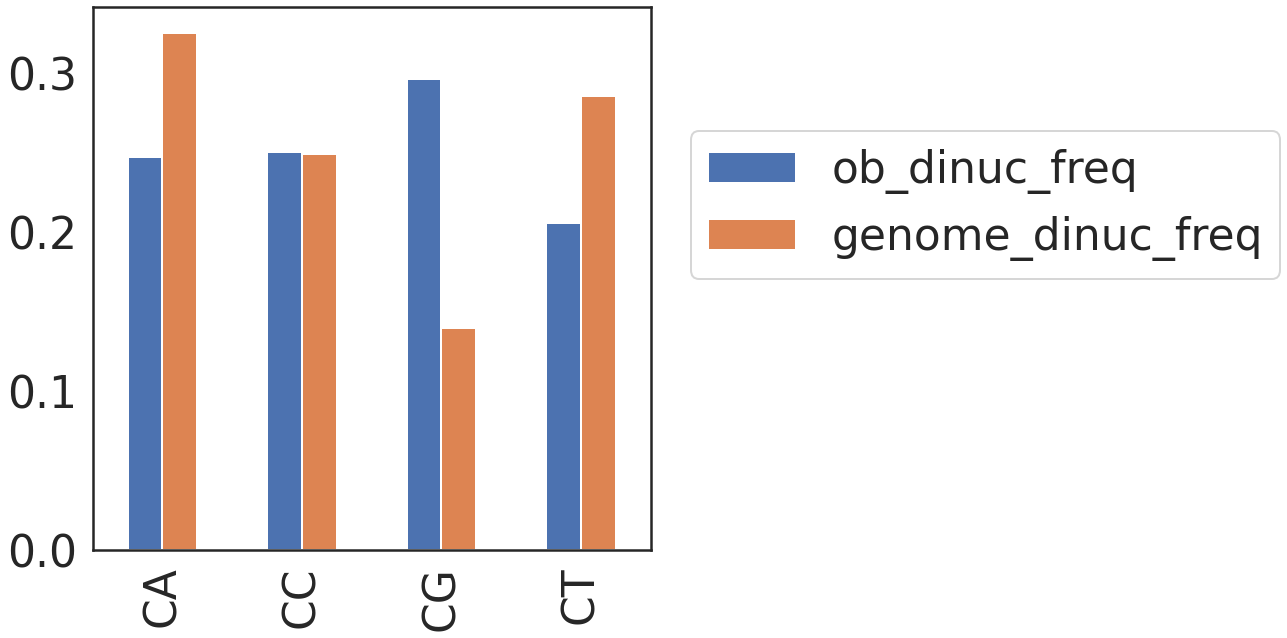

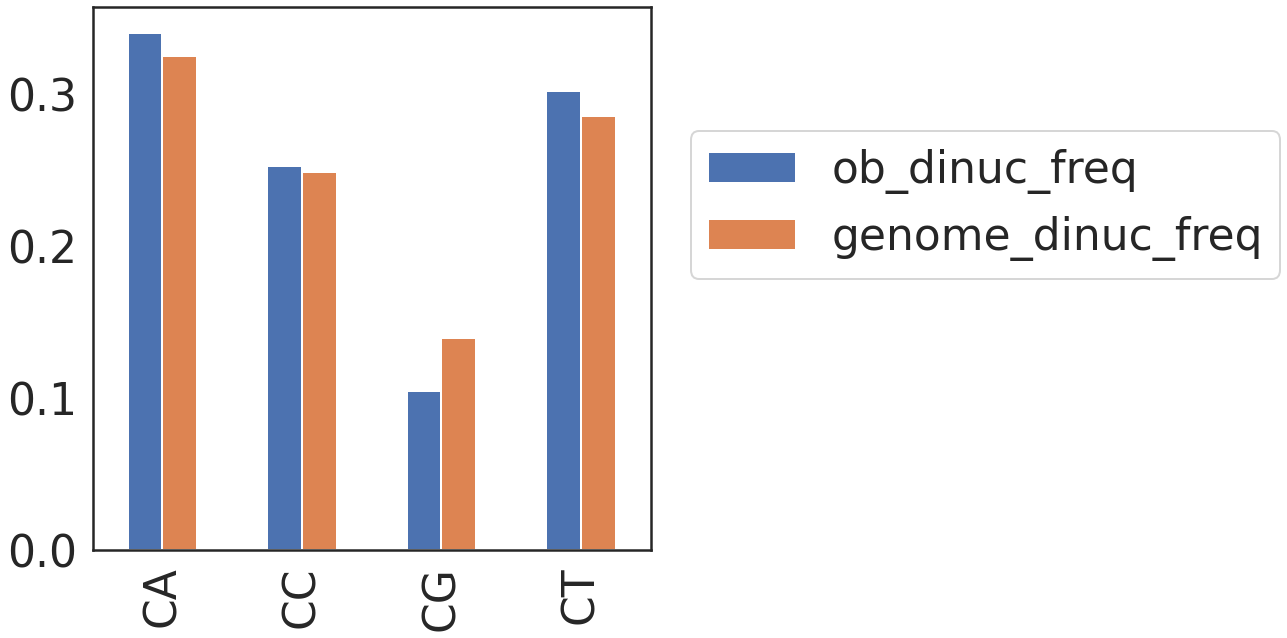

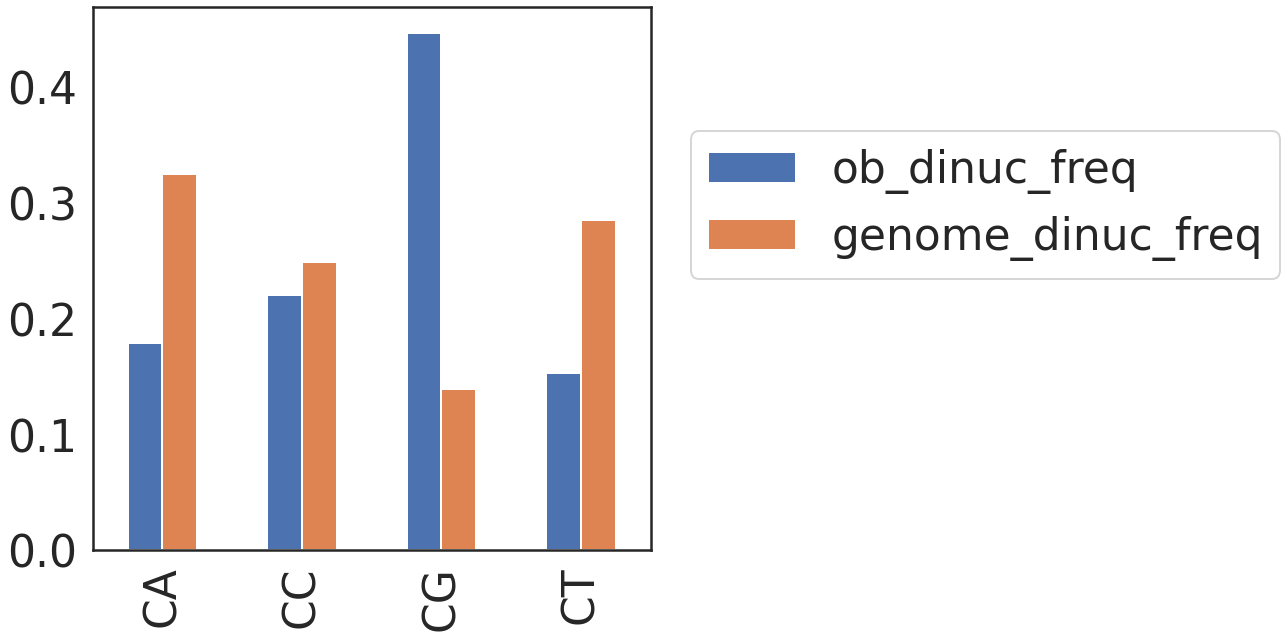

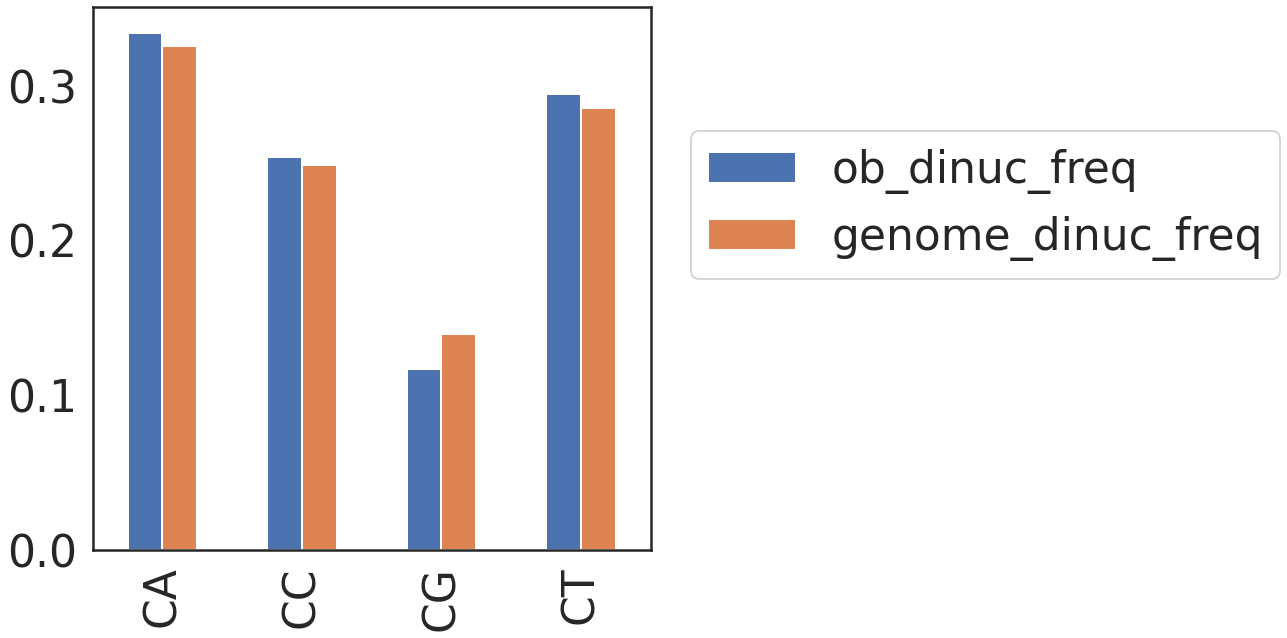

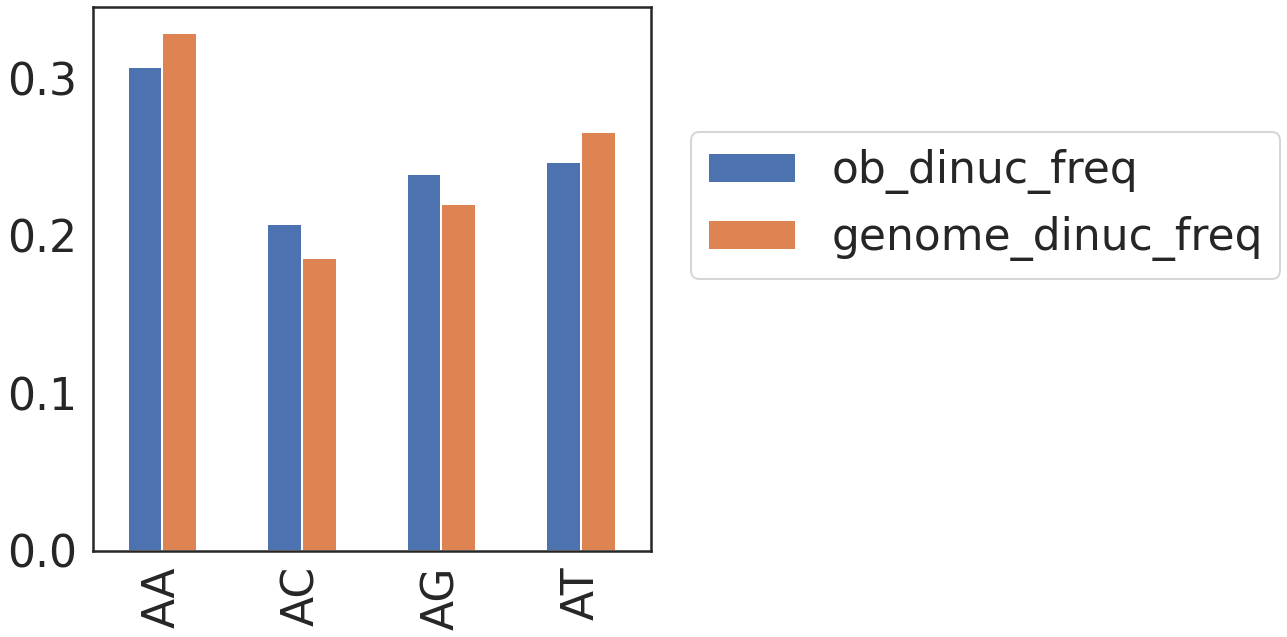

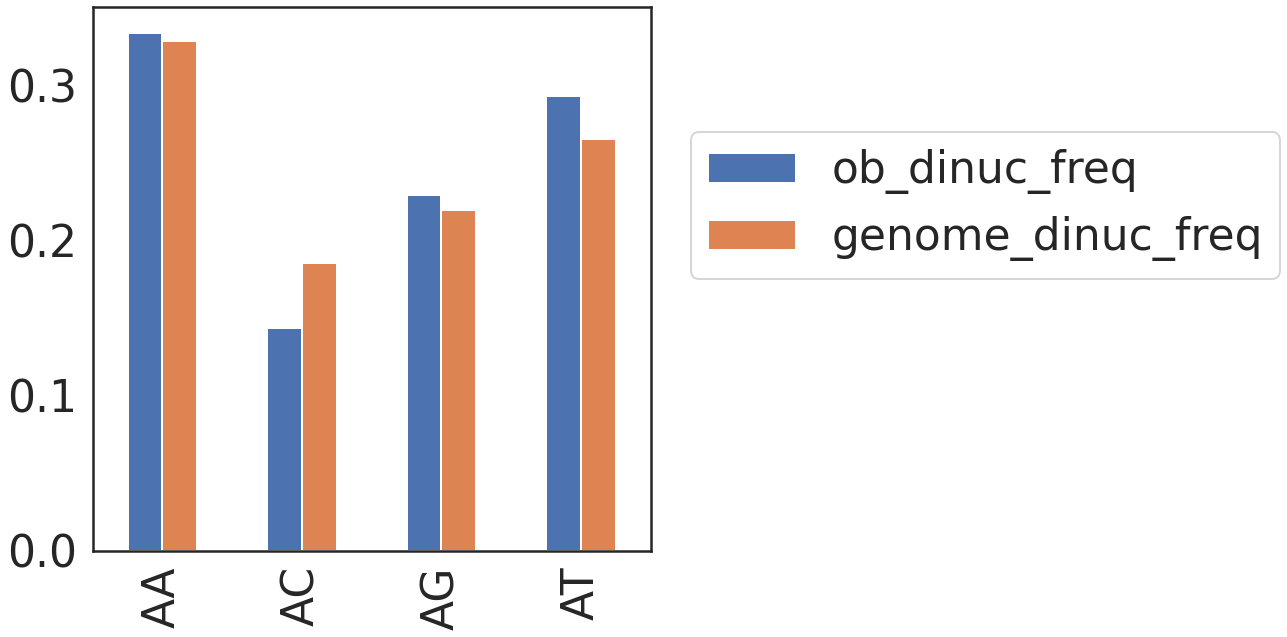

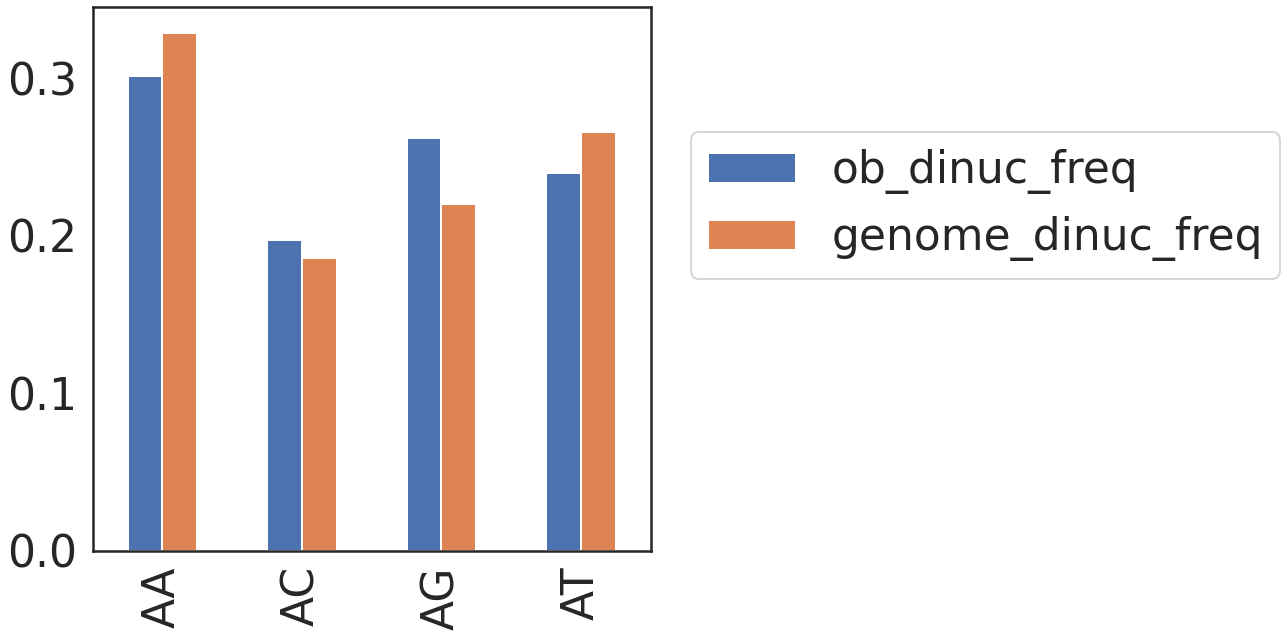

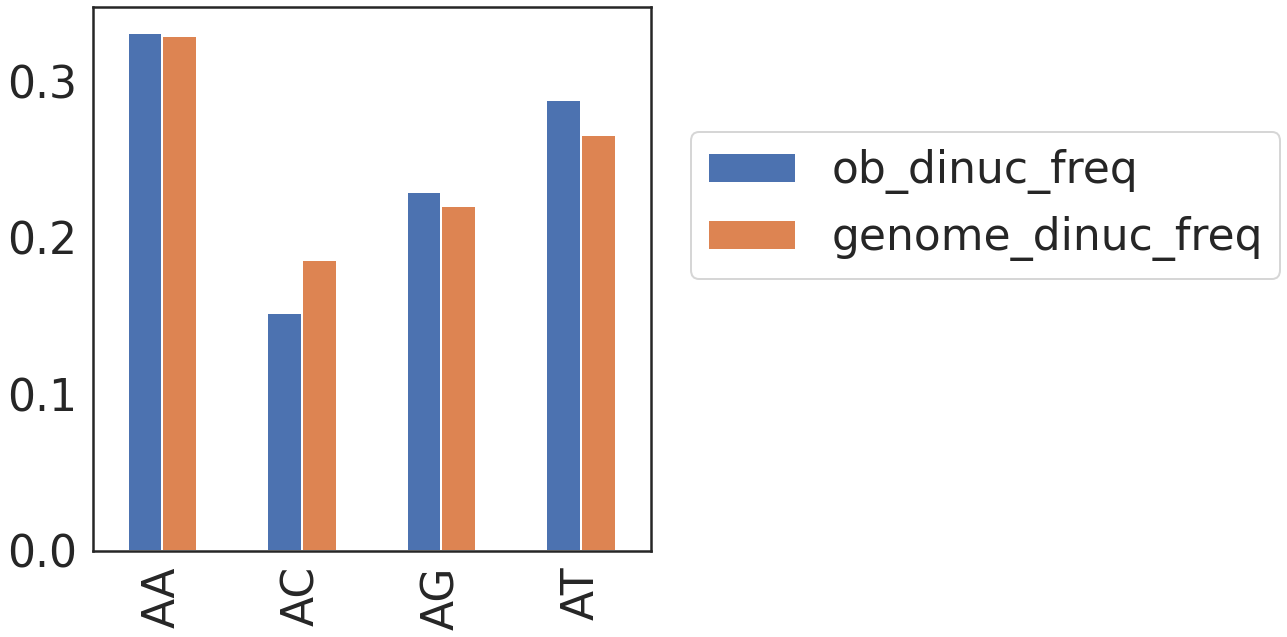

In [93]:
for key, value in dinuc_df_dict.items():
    fig , ax = plt.subplots(figsize=(10,10))
    tmp_df = get_dinuc_freq_df(genome_dinuc_df, dinuc_df_dict[key])
    print(tmp_df)
    #tmp_df2 = tmp_df.loc[sorted(tmp_df.index.tolist()), ['ob_dinuc_freq', 'genome_dinuc_freq']]
    #ax.bar(x= tmp_df2.index, height= tmp_df2['ob_dinuc_freq'])
    #ax.bar(x= tmp_df2.index, height= tmp_df2['genome_dinuc_freq'])
    tmp_df.loc[sorted(tmp_df.index.tolist()), ['ob_dinuc_freq', 'genome_dinuc_freq']].plot.bar(ax =ax ,legend=False)
    #plt.title(key)
    out_fn = os.path.join(OUTDIR,'Observed_methylation_pattern'+ key + '.png')
    lgd = ax.legend(bbox_to_anchor=(1.6, 0.5), loc=8, borderaxespad=0.)
    fig.savefig(out_fn, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=600)
    #plt.legend(loc='upper center')

In [94]:
Image(out_fn)

    ob_dinuc_freq  ob_dinuc_total  genome_dinuc_total  genome_dinuc_freq  \
CA       0.251703         2689564            25015364           0.325412   
CC       0.254215         2716413            19139188           0.248972   
CT       0.209829         2242129            21976219           0.285877   
CG       0.284253         3037379            10742142           0.139739   

    meth_freq  
CA   0.107516  
CC   0.141929  
CT   0.102025  
CG   0.282754  
    ob_dinuc_freq  ob_dinuc_total  genome_dinuc_total  genome_dinuc_freq  \
CT       0.301016        17026588            21976219           0.285877   
CC       0.252038        14256188            19139188           0.248972   
CA       0.339844        19222842            25015364           0.325412   
CG       0.107102         6058094            10742142           0.139739   

    meth_freq  
CT   0.774773  
CC   0.744869  
CA   0.768441  
CG   0.563956  
    ob_dinuc_freq  ob_dinuc_total  genome_dinuc_total  genome_dinuc_freq  \
CG

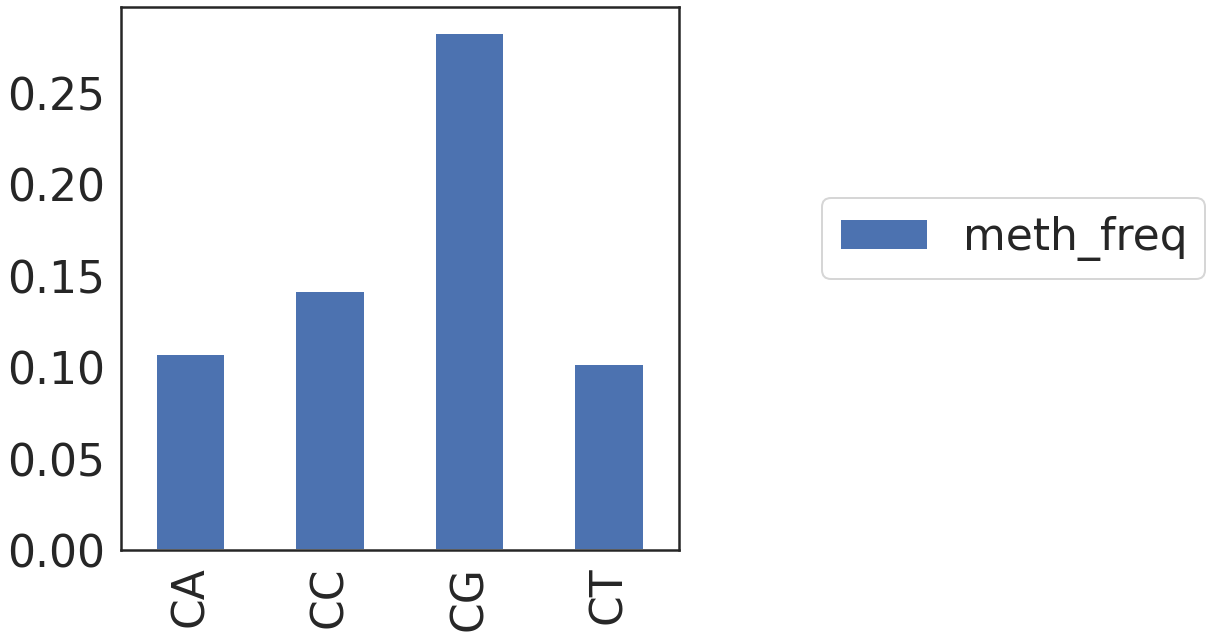

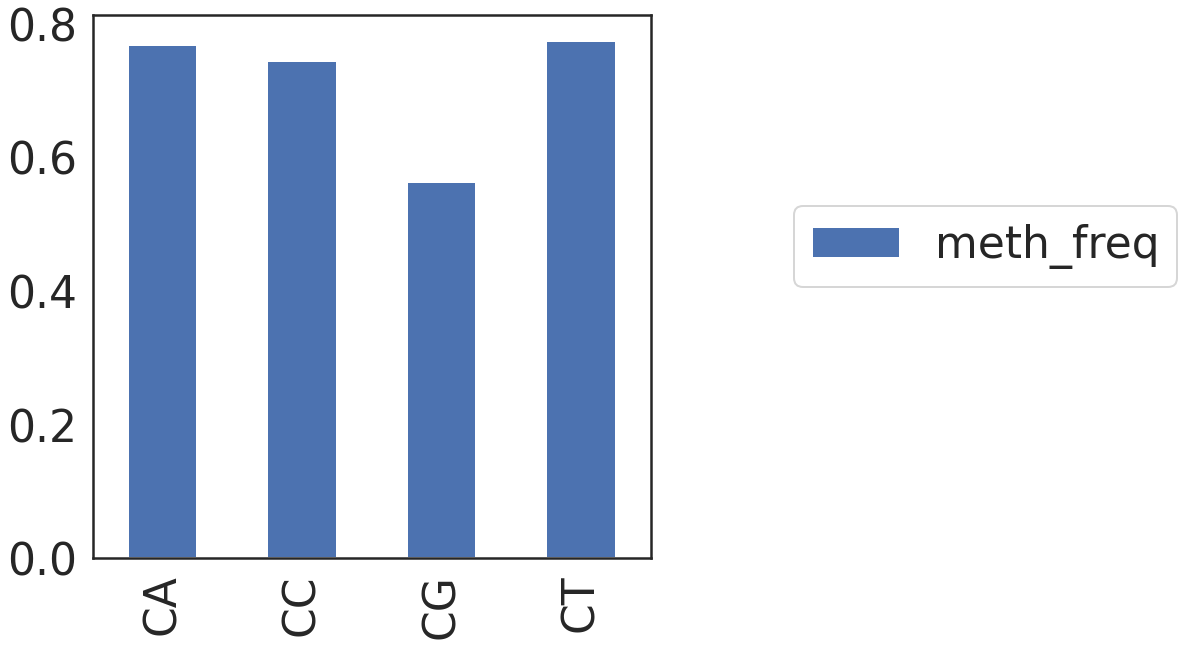

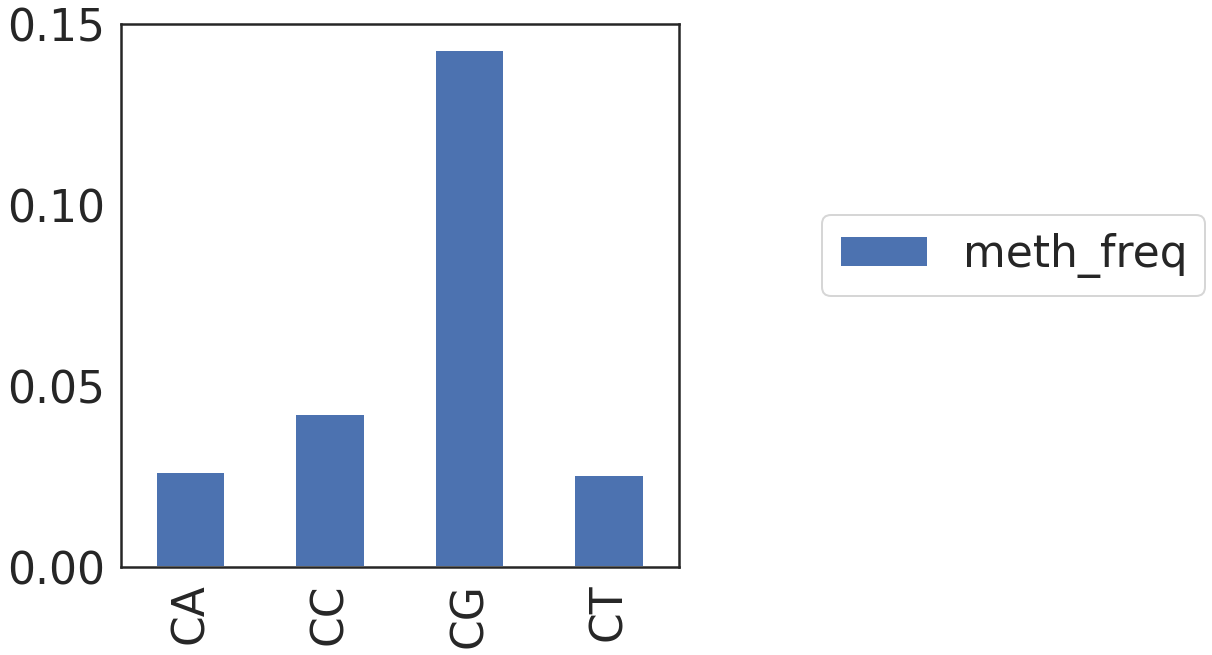

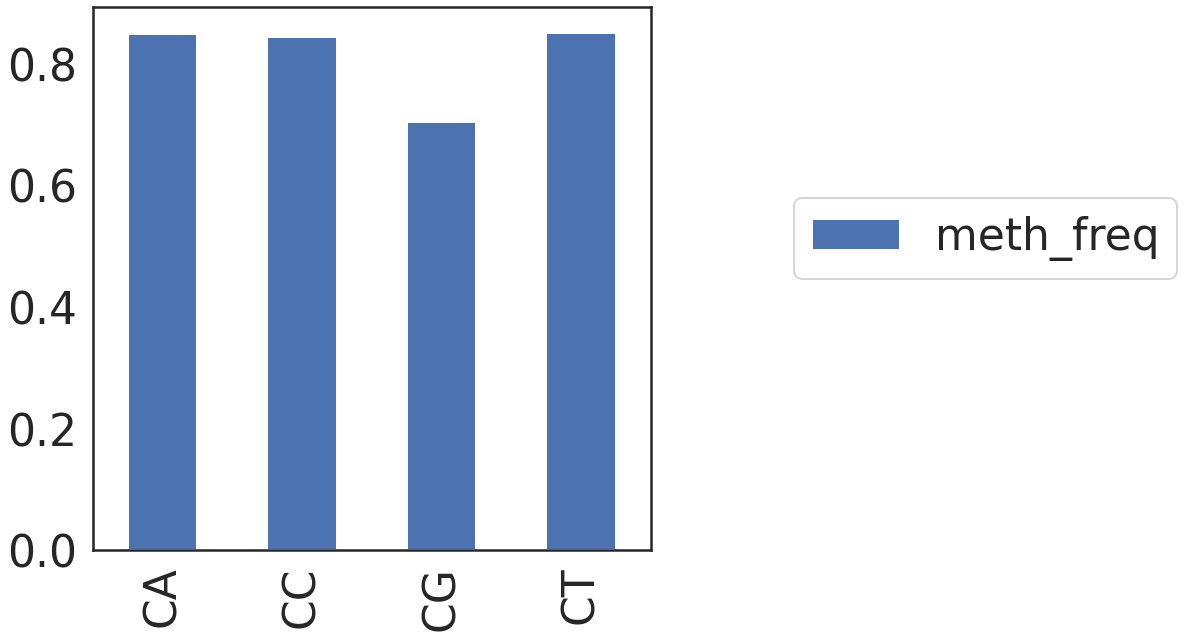

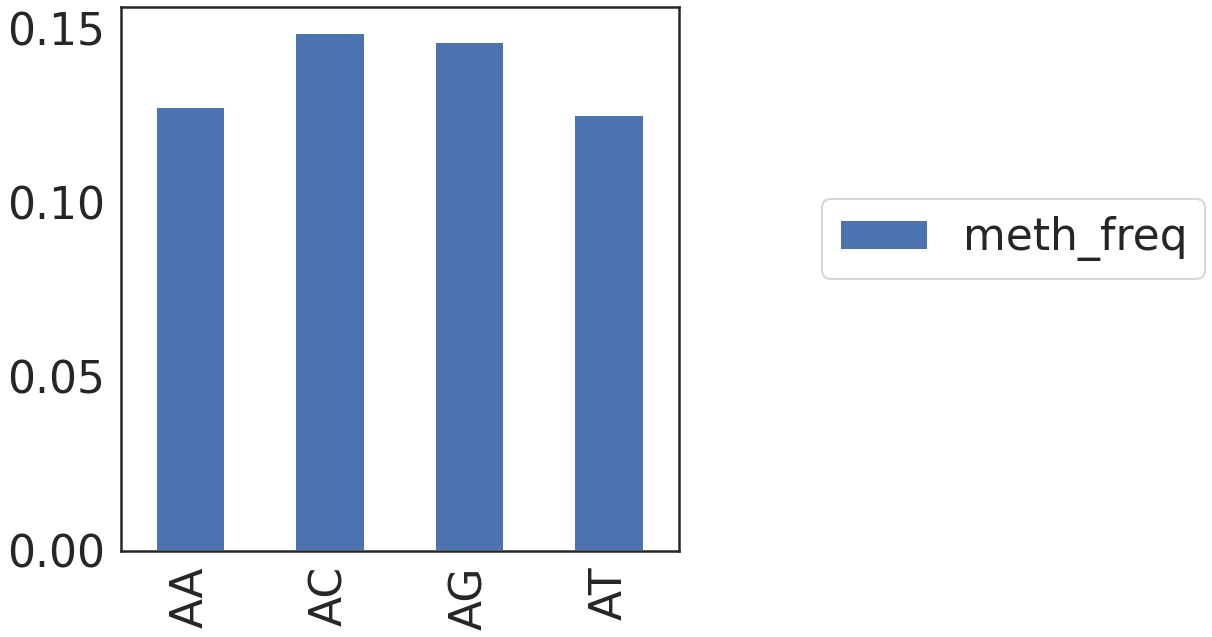

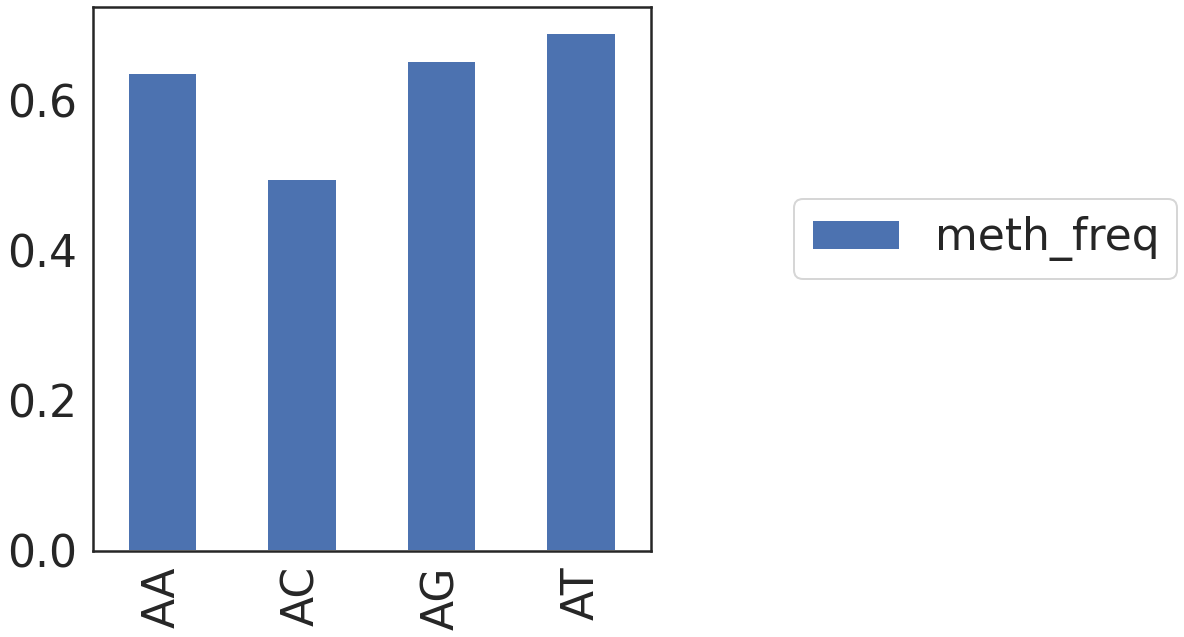

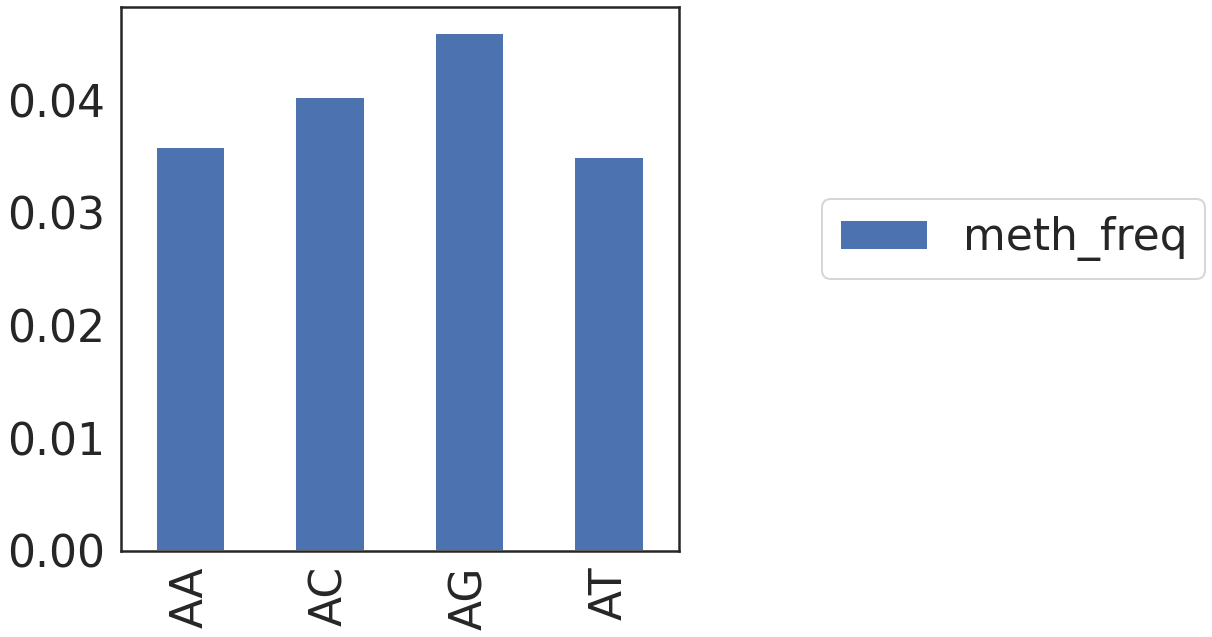

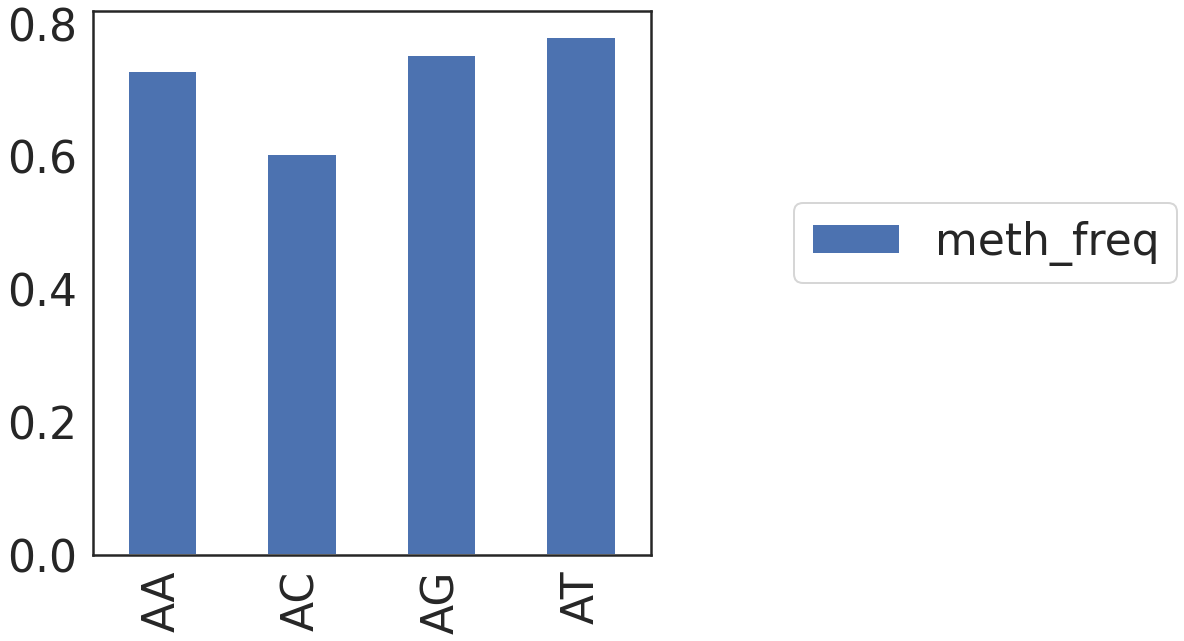

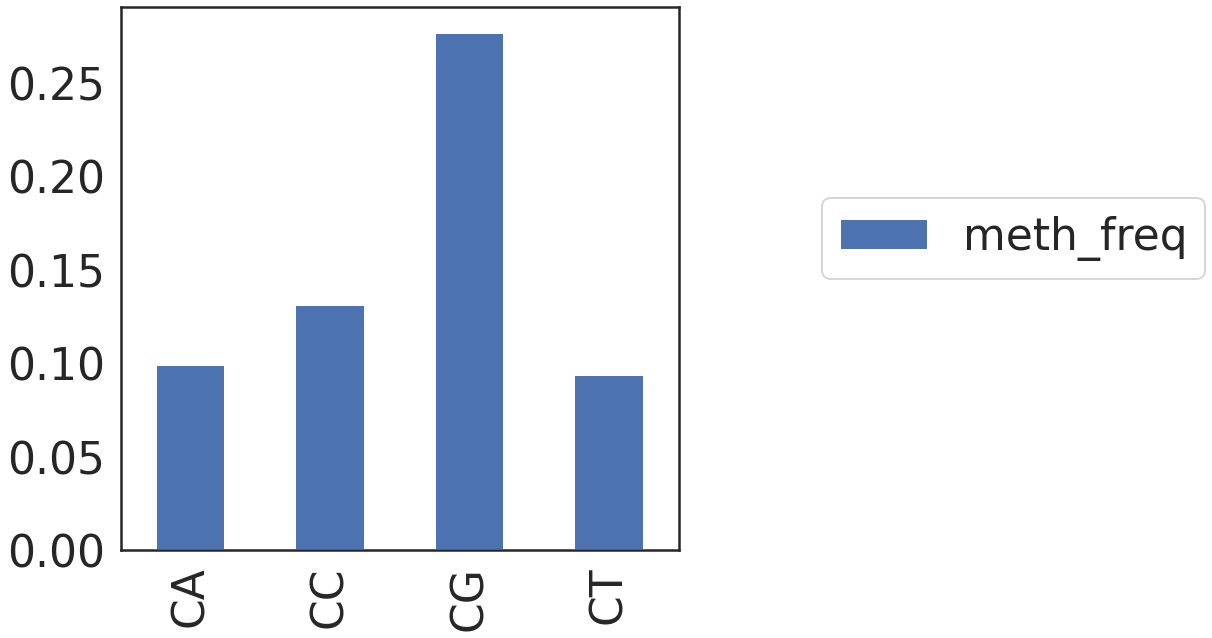

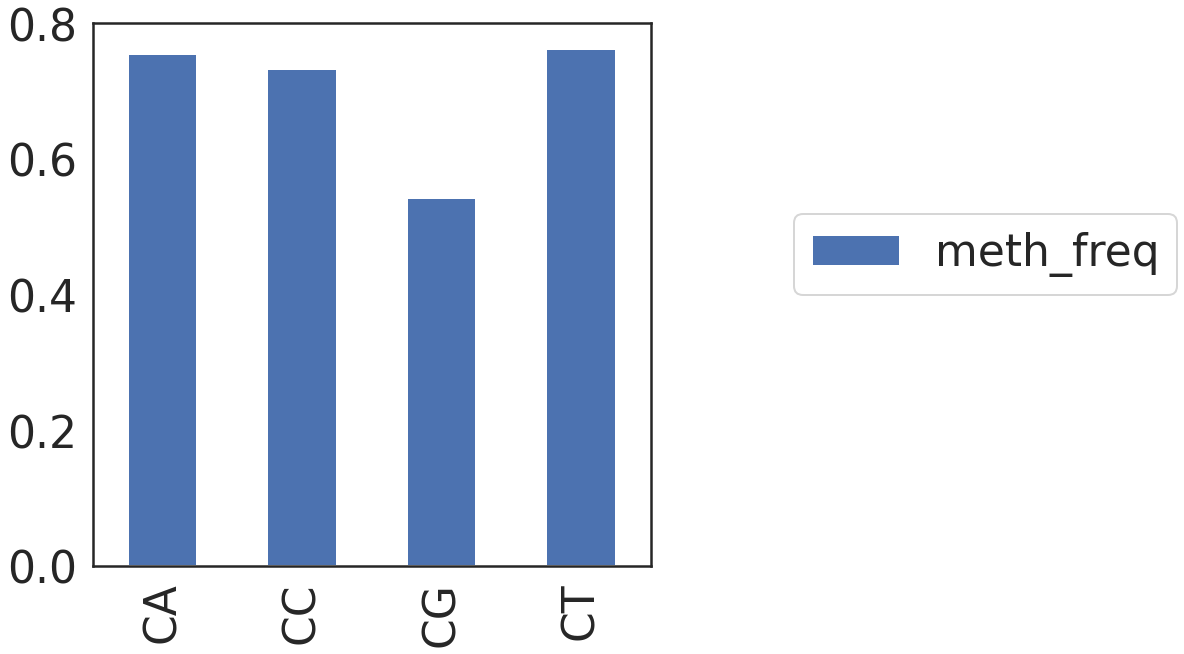

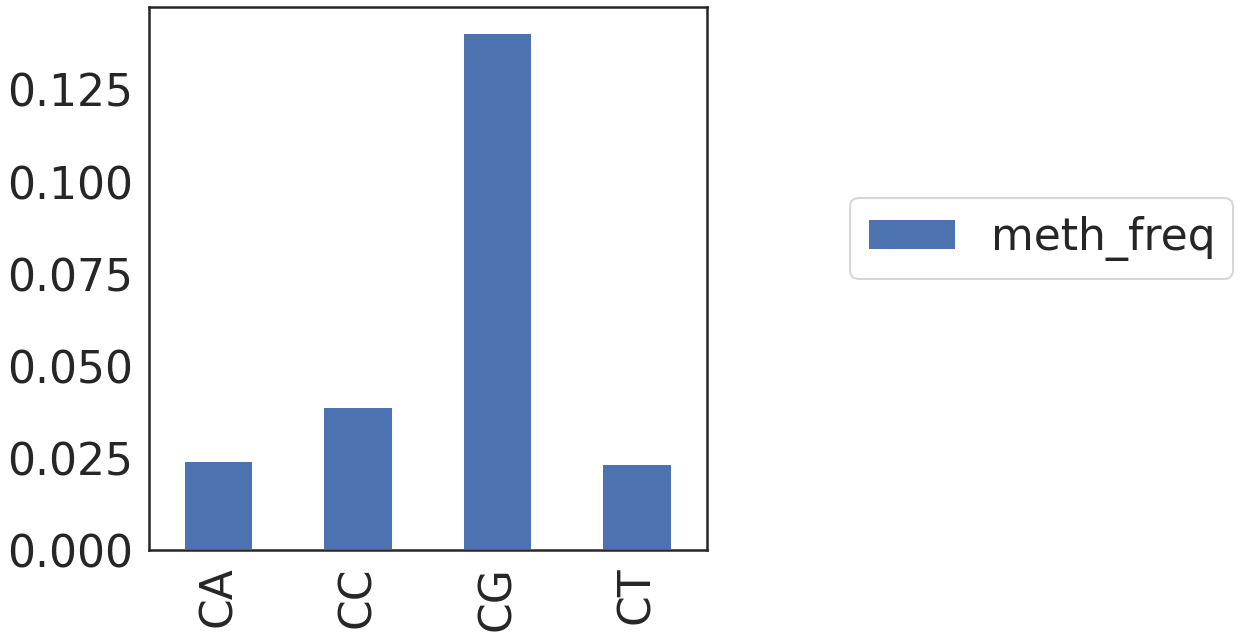

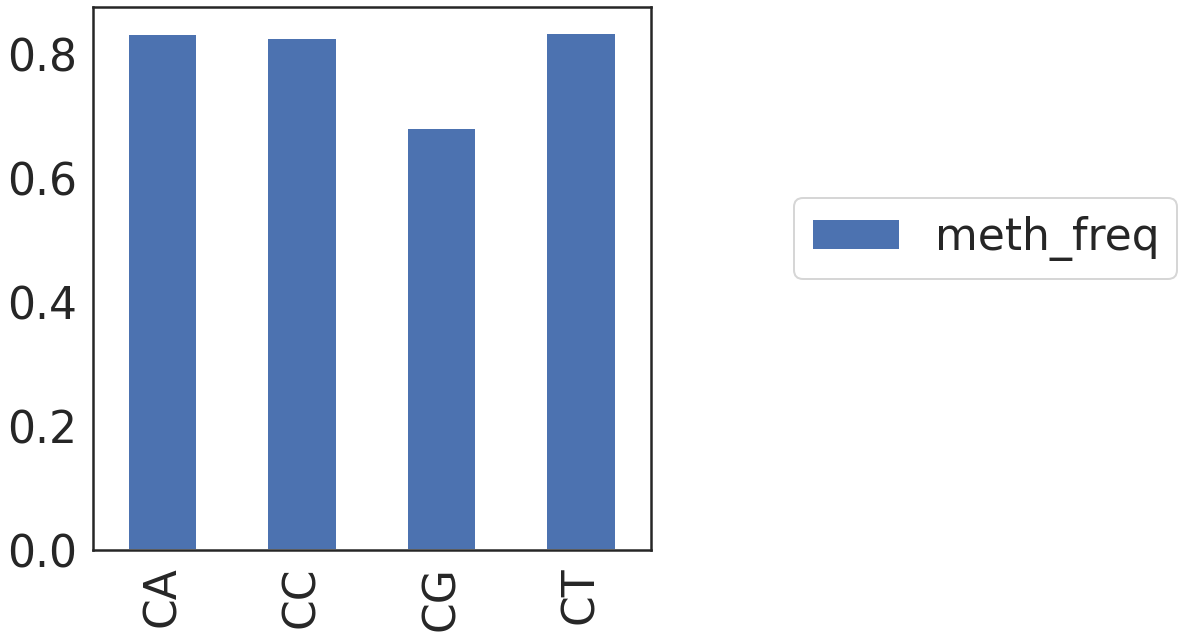

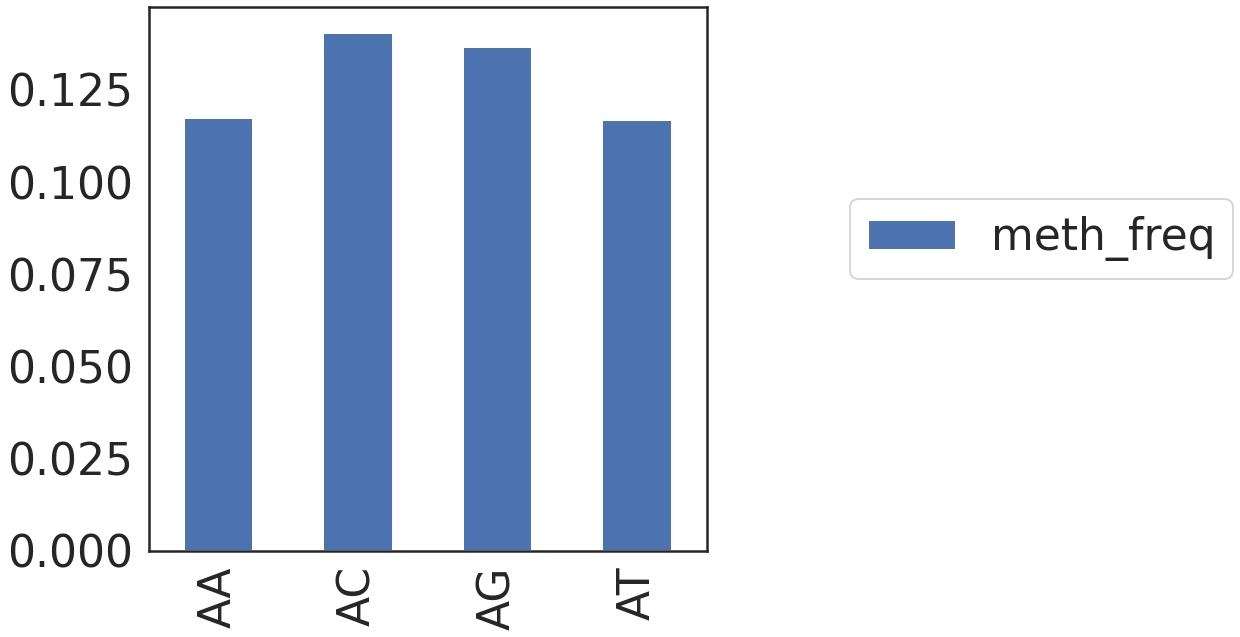

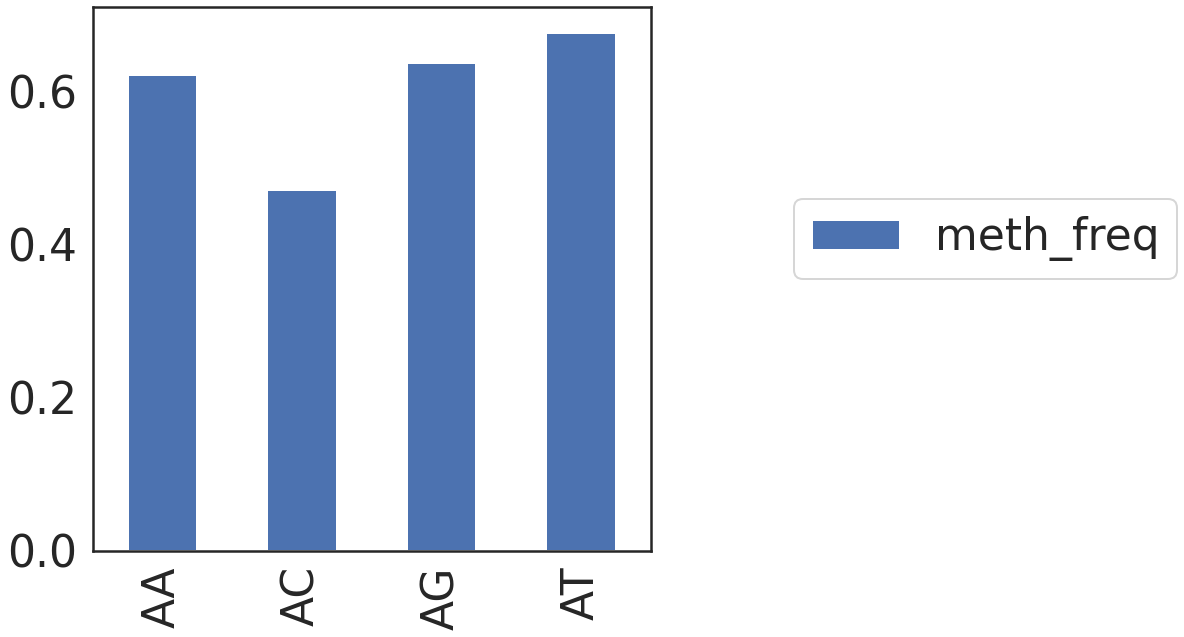

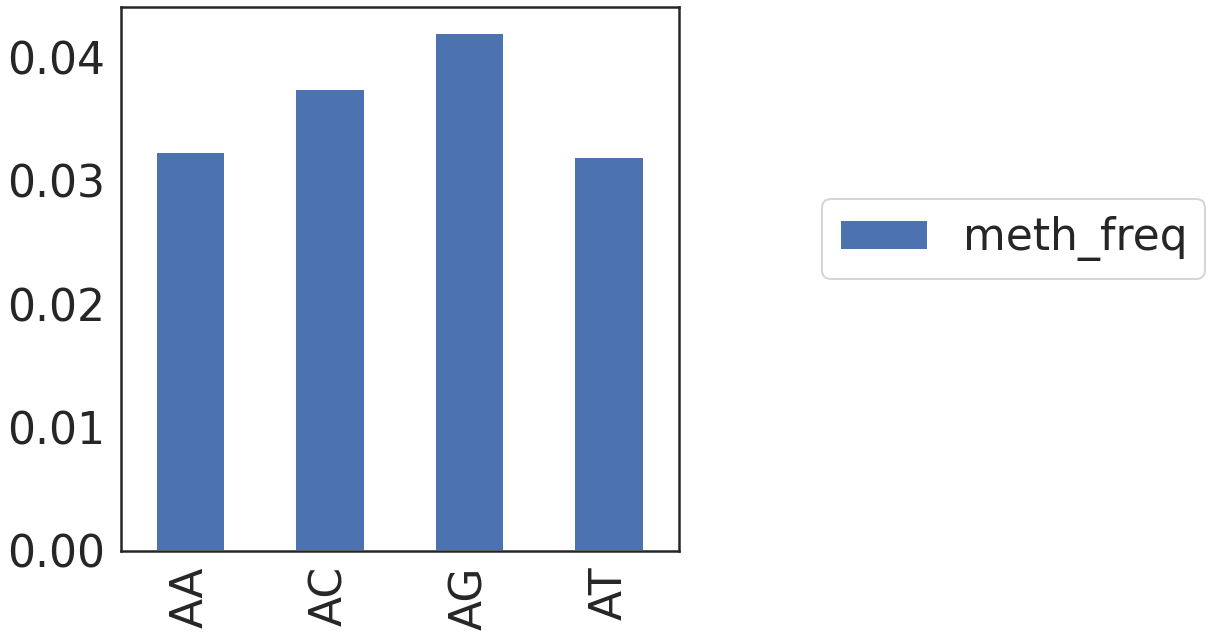

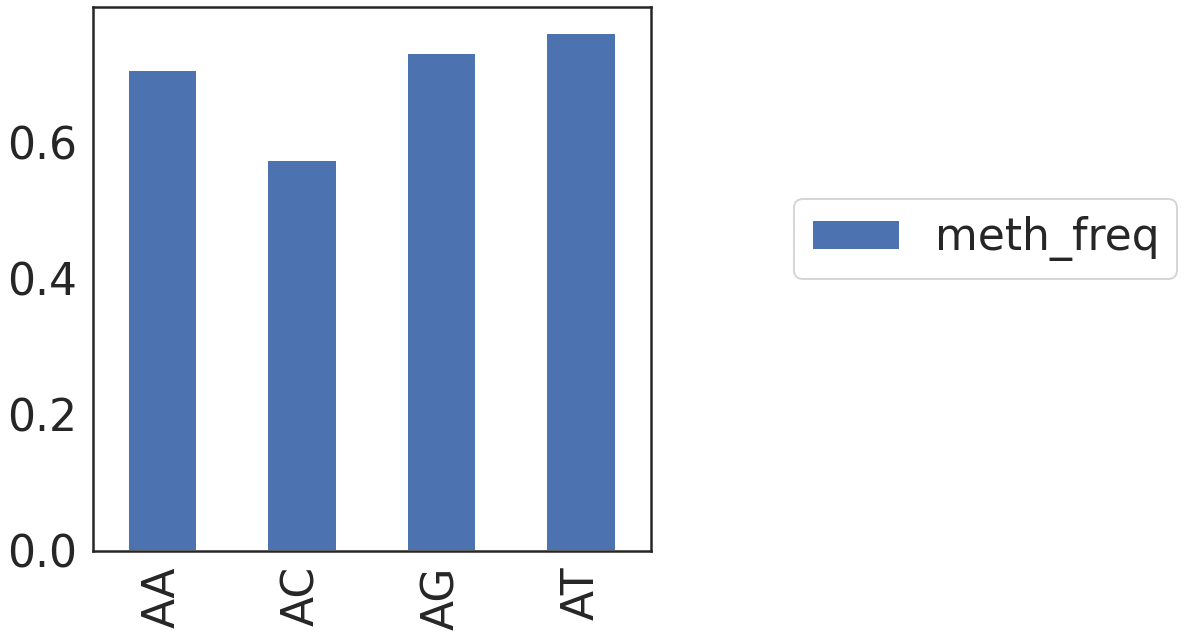

In [91]:
for key, value in dinuc_df_dict.items():
    fig , ax = plt.subplots(figsize=(10,10))
    tmp_df = get_dinuc_freq_df(genome_dinuc_df, dinuc_df_dict[key])
    print(tmp_df)
    tmp_df.loc[sorted(tmp_df.index.tolist()), ['meth_freq']].plot.bar(ax =ax ,legend=False)
    #plt.title(key)
    out_fn = os.path.join(OUTDIR, 'Methylation_frequency_' +  key + '.png')
    #plt.tight_layout()
    lgd = ax.legend(bbox_to_anchor=(1.6, 0.5), loc=8, borderaxespad=0.)
    fig.savefig(out_fn, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=600)


In [92]:
Image(out_fn)